# Word Embeddings

### Introduction

In this notebook, we will learn how to train our own word embeddings using two approaches, then explore some of the fun things you can do with them.

Word Embeddings are a type of word representation that allows words with similar meaning to have a similar representation. They are a distributed representation for text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging natural language processing problems.

For reference and additional details, please go through Chapter 6 of [the SLP3 book](https://web.stanford.edu/~jurafsky/slp3) and this [nice writeup by Jay Alammar](https://jalammar.github.io/illustrated-word2vec/).


## Part 1 - Implementing `word2vec`

In this part, we will implement the `word2vec` algorithm. 

While `word2vec` is more of a _framework_ for learning word embeddings, we will focus on the `SkipGram` model, specifically how it was trained in the original 2013 paper. Your primary references for understanding this algorithm will be the lecture slides, and the two aforementioned links.

You will be working with the *greatest* work of literature ever written: ~~the Bee Movie script~~ **The Lord of the Rings** - specifically the first book, *The Fellowship of the Ring*. 

While this book is a masterpiece, it can take a while to train embeddings on the entire text. So, we will be working with a subset of the text. 

In [1]:
# Import in the libraries
# Note: you are NOT allowed to use any other libraries or functions outside of these

import os
import re
from typing import List, Union

import numpy as np
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\khuze\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Preparing our raw data
In the cell below, we will read in the data as one very long string.
This will be followed by creating a `Dataset` class that will be helpful in working with your dataset when training the model. The `Dataset` class should have the following attributes/methods:
- `__init__(self, data)` - the constructor that takes in the data and initializes the necessary attributes.
- `data` - the data that is passed in. You can apply a very simple preprocessing pipeline: (1) substitute `,!?;-` (i.e. these five punctuation marks) with a period (i.e. `.`), (2) lowercase all the text, and (3) extract only those characters that are alphabetic or a period.
- `tokens` - a list of all the tokens in the data. It might be helpful to use the `nltk.word_tokenize` function already imported for you.
- `vocab` - a set of all the unique tokens in the data. Be sure to sort this and convert it to a list as to have a consistent ordering.
- `vocab_size` - the length of the vocabulary.
- `stoi` - a mapping from the word (s) to their index (i) in the vocab. It is important to have sorted your vocab before creating this mapping.
- `itos` - a mapping from the index (i) to the word (s) in the vocab.
The two mappings will be helpful in fetching your Embeddings later on, since your Embeddings will be a matrix of shape `(vocab_size, embedding_dim)` and the ordering will be dependent on your vocabulary's ordering.
You might find the following boilerplate helpful:
```python
# Substitute the specified punctuation with periods
data = ...
# Tokenize the above plaintext to get a list of tokens
tokens = ...
# Only grab those tokens that are alphabetic or a period (can use .isalpha() here, and a == check for '.') - a list comprehension might be helpful
tokens = ...
# Lowercase all the tokens
tokens = ...

In [2]:
# Read in the data
with open("./The Fellowship of the Ring.txt") as f:
    data = f.read()

print(data[:200]) # print out the first 200 chars
len(data)

J. R. R. Tolkien Â— The Lord Of The Rings. (1/4)
-----------------------------------------------


     THE LORD OF THE RINGS

              by

     J. R. R. TOLKIEN



 Part 1: The Fellowship of the


1025058

In [3]:
class Dataset:

    def __init__(self, data: str):
                
        self.data = data
        self.preprocess_data()
        self.tokens = nltk.word_tokenize(self.data)

        self.vocab = sorted(set(self.tokens))
        self.vocab_size = len(self.vocab)
        
        self.stoi = {word: i for i, word in enumerate(self.vocab)}
        self.itos = {i: word for word, i in self.stoi.items()}

    def preprocess_data(self):
        # Step 1: Substitute all punctuation with a period, lowercase all text,
        # and extract only alphabetic characters and periods.
        
        text = self.data

        # Substitute `,!?;-` with a period
        text = re.sub(r'[,\!?;-]', '', text)
        # Lowercase all the text
        text = text.lower()
        # Extract only alphabetic characters or a period
        text = re.sub('[^a-z .]+', '', text)

        self.data = text
    
    def __len__(self):
        return len(self.tokens)


dataset = Dataset(data)
print(f"Number of tokens in dataset: {len(dataset)}")

Number of tokens in dataset: 199141


In [4]:
dataset.stoi

{'.': 0,
 '..': 1,
 '...': 2,
 '.but': 3,
 '.dear': 4,
 'a': 5,
 'abandon': 6,
 'abandoned': 7,
 'abandons': 8,
 'abashed': 9,
 'abbreviated': 10,
 'abide': 11,
 'able': 12,
 'aboard': 13,
 'abode': 14,
 'abominable': 15,
 'about': 16,
 'above': 17,
 'abreast': 18,
 'abroad': 19,
 'absence': 20,
 'absorbed': 21,
 'abstracts': 22,
 'absurd': 23,
 'absurdly': 24,
 'abundant': 25,
 'abundantly': 26,
 'abyss': 27,
 'accepted': 28,
 'accepting': 29,
 'accessory': 30,
 'accident': 31,
 'accomplish': 32,
 'accomplished': 33,
 'accord': 34,
 'accorded': 35,
 'according': 36,
 'account': 37,
 'accounted': 38,
 'accounting': 39,
 'accounts': 40,
 'accurate': 41,
 'accursed': 42,
 'accusing': 43,
 'accustomed': 44,
 'ache': 45,
 'ached': 46,
 'achieve': 47,
 'achieved': 48,
 'acknowledge': 49,
 'acknowledged': 50,
 'acorn': 51,
 'acquire': 52,
 'acquired': 53,
 'acrobatics': 54,
 'across': 55,
 'actual': 56,
 'actually': 57,
 'acutting': 58,
 'adamant': 59,
 'add': 60,
 'added': 61,
 'adding': 62

### Creating our dataset

Now for the fun part of the dataset preparation: creating the windows!

<center>
<img src="https://jalammar.github.io/images/word2vec/skipgram-sliding-window-5.png">
</center>

We will implement a function below to slide a window over the text to create  `(context, target)` pairs.

We will adopt the following convention: the target word is at the center of a window, and the context words are the words surrounding the target word, with `ctx_size` tokens on either side.

We will implement this to work with a list of tokens (whether that be in string-form, or as indices). The function should return a list of tuples, where each tuple is a pair of the form `(context, target)`.

In [5]:
# Create the dataset using the sliding window approach
def get_windows(
        data: List[Union[str, int]], 
        ctx_size: int
        ):
    '''
    Generates the windows to be used later for dataset creation

    Takes in a list of tokens (as strings or integers/indices) and a context size
    This will slide a window of size 2*ctx_size + 1 over the data producing
    the a list of center words, and the corresponding context words

    Note that ctx_size is the number of context words on EITHER side of the center word
    e.g.
    > get_windows(["I", "love", "my", "dog", "!"], 2) produces the first (and only) window to be
    (["I", "love", "dog", "!"], "my")
    '''
    
    outside_words = []
    center_words = []

    total = len(data)
    first = ctx_size
    last = total - ctx_size

    for i in range(first,last):

        before = []
        for j in range(i-ctx_size,i):
            before.append(data[j])
        center = data[i]
        after = []
        for j in range(i+1,i+ctx_size+1):
            after.append(data[j])

        center_words.append(center)
        outside_words.append(before + after)
            
    return outside_words, center_words

owords, cwords = get_windows(
    nltk.word_tokenize("hello how are you. i am under the water. please help me."),
    2
)

for i in range(len(owords)):
    print(f"{owords[i]} ---> {cwords[i]}")

assert owords[1] == ['how', 'are', '.', 'i'] and cwords[1] == 'you' and len(owords) == 11, \
    "Test failed"

['hello', 'how', 'you', '.'] ---> are
['how', 'are', '.', 'i'] ---> you
['are', 'you', 'i', 'am'] ---> .
['you', '.', 'am', 'under'] ---> i
['.', 'i', 'under', 'the'] ---> am
['i', 'am', 'the', 'water'] ---> under
['am', 'under', 'water', '.'] ---> the
['under', 'the', '.', 'please'] ---> water
['the', 'water', 'please', 'help'] ---> .
['water', '.', 'help', 'me'] ---> please
['.', 'please', 'me', '.'] ---> help


A key component of the algorithm was **Negative Sampling** so that our model was able to see occurences of words that _didn't_ appear in the context. We will implement this in the next part.

The `sample_neg_word` is a utility function that will continue sampling a word from the specific vocabulary until it is not the word we have specified. 

When actually implementing the negative sampling, we will sample tokens that are _not_ the center word only - many implementations ignore the exclusion of the context words, so we will do this same simplification here.

In [6]:
# To create the dataset, we need to get positive and negative samples according to the windows made
def sample_neg_word(to_exclude: str,
                    vocab: List[str]):
        '''
        Samples a negative word from the vocab, excluding the word to_exclude
        '''
        sample_word = np.random.choice(vocab)
        if sample_word == to_exclude:
                sample_word = sample_neg_word(to_exclude,vocab)
        
        return sample_word

### Implementing the actual model

Now we will make use of the `Dataset` class and the `sample_neg_word` function to implement the `SkipGram` model.

The steps of the model:

1. Randomly initialize two matrices: `W` and `C` of shape `(vocab_size, embedding_dim)`. These will be the center/target word and context embeddings respectively.

2. Being looping through each `(context, target)` pair in the dataset.

    2.1. For each pair, sample `K` negative words from the vocabulary.

    2.2. Compute the loss for the context and target word, as well as the negative samples.

    2.3. Compute the gradients for the context and target word, as well as the `K` negative samples.

    2.4. For each of these computed gradients, update the corresponding embeddings.

3. Repeat this process for `num_epochs`.


The formulas for the Loss function and the gradients:

$$L_{CE} = -\log \sigma(c_{pos} \cdot w) - \sum_{i=1}^{K} \log \sigma(-c_{neg_i} \cdot w)$$

$$\frac{\partial L_{CE}}{\partial w} = [\sigma(c_{pos} \cdot w) - 1]c_{pos} + \sum_{i=1}^{K} [\sigma(c_{neg_i} \cdot w)]c_{neg_i}$$

$$\frac{\partial L_{CE}}{\partial c_{pos}} = [\sigma(c_{pos} \cdot w) - 1]w$$

$$\frac{\partial L_{CE}}{\partial c_{neg_i}} = \sigma(c_{neg_i} \cdot w)w$$

Where $c_{pos}$ is the context word, $w$ is the target word, and $c_{neg_i}$ is the $i^{th}$ negative sample.

In [7]:
# Create the data
# The dataset is very large, so we will only use the first 2000 tokens for now
# There will be 3 words on each side of the center word
context_words, target_words = get_windows(
    dataset.tokens[:2000], 
    ctx_size=3
)

In [8]:
def sigmoid(x : np.ndarray):
    return 1 / (1 + np.exp(-x))

class word2vec:

    def __init__(self, 
                 vocab_size : int, 
                 stoi : dict, 
                 emb_dim : int):

        self.W = np.random.rand(vocab_size, emb_dim)
        self.C = np.random.rand(vocab_size, emb_dim)
        self.stoi = stoi

        self.vocab = list(stoi.keys())
                

    def __call__(self, x : int):
        return (self.W[x] + self.C[x]) / 2
    
    
    def encode(self, x : Union[str, List[str]]):
        return [dataset.stoi[i] for i in x] if isinstance(x, list) else self.stoi[x]

    def fit(self, 
            context_words : List[List[str]], 
            target_words : List[str], 
            num_epochs : int = 5, 
            learning_rate : float = 0.001, 
            K : int = 5):
        '''
        Runs the training algorithm for the word2vec model
        '''
 
        losses = []

        for epoch in range(num_epochs):

            epoch_loss = 0.0

            for i in range(len(target_words)):
                context = context_words[i]
                center = target_words[i]

                target_index = self.encode(center)
                w = self.W[target_index]

                # Loop for each context, target word pair
                for pos_word in context:
                    # Getting K samples:
                    neg_samples =  [sample_neg_word(center,self.vocab) for _ in range(K)] 

                    # Compute Loss
                    c_pos_index = self.encode(pos_word)
                    c_pos = self.C[c_pos_index]
                    pair_loss = - np.log(sigmoid(np.dot(c_pos, w)))

                    # Compute Gradients
                    d_L_wrt_w = (sigmoid(np.dot(c_pos, w)) - 1) * c_pos

                    for neg_word in neg_samples:
                        c_neg_index = self.encode(neg_word) 
                        c_neg = self.C[c_neg_index]
                        # Adding to loss
                        pair_loss -= np.log(sigmoid(np.dot(-c_neg, w)))
                        # Adding to gradient of W
                        d_L_wrt_w += (sigmoid(np.dot(c_neg, w))) * c_neg

                        # Updating C for negative sample
                        d_L_wrt_c_neg = (sigmoid(np.dot(c_neg, w))) * w
                        self.C[c_neg_index] = self.C[c_neg_index] - learning_rate*d_L_wrt_c_neg

                    # Update Epoch Loss
                    epoch_loss += pair_loss

                    # Update W  
                    self.W[target_index] = self.W[target_index] - learning_rate*d_L_wrt_w
                    # Update C for positive
                    d_L_wrt_cpos = (sigmoid(np.dot(c_pos, w)) - 1) * w
                    self.C[c_pos_index] = self.C[c_pos_index] - learning_rate*d_L_wrt_cpos

            epoch_loss = epoch_loss / len(target_words)
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.3f}")
            losses.append(epoch_loss)

        return losses

w2v_model = word2vec(vocab_size=dataset.vocab_size,
                     stoi=dataset.stoi,
                     emb_dim=100)

Epoch 1/10 - Loss: 520.450
Epoch 2/10 - Loss: 392.419
Epoch 3/10 - Loss: 336.167
Epoch 4/10 - Loss: 298.653
Epoch 5/10 - Loss: 271.760
Epoch 6/10 - Loss: 248.944
Epoch 7/10 - Loss: 229.061
Epoch 8/10 - Loss: 210.967
Epoch 9/10 - Loss: 195.236
Epoch 10/10 - Loss: 181.136


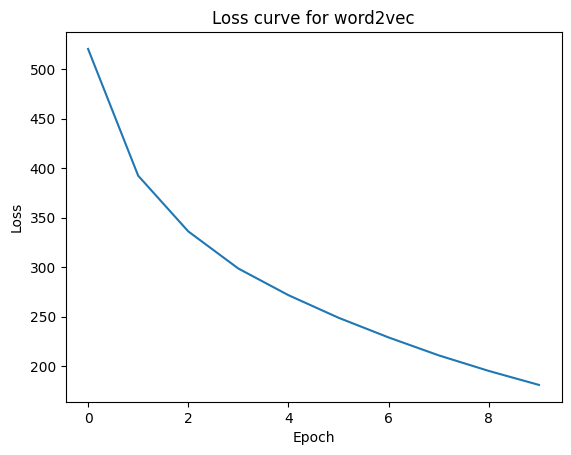

In [9]:
losses = w2v_model.fit(context_words,
                       target_words,
                       num_epochs=10)

# Plot the loss curves
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curve for word2vec")
plt.show()

### Cosine Similarity

Now to actually examine the embeddings trained. We will do one small exercise involving checking the similarity of pairs of words in the vocabulary.

This means we will need to implement the Cosine Similarity function. The Cosine Similarity between two vectors $u$ and $v$ is given by:
$$ \text{Cosine Similarity}(u, v) = \frac{u \cdot v}{||u|| \cdot ||v||} $$

We will then use this function on a series of predefined word pairs to see how similar they are in the embedding space: this entails that they showed up in similar contexts in the text.

Some notes to make sense of what we _should_ see:

- `Frodo` and `Sam` are best friends, so they should have a high similarity.

- `Gandalf` has been referred to as Gandalf the `White`.

- `Frodo` must make an arduous journey to `Mordor`.

- `Aragorn` is close to Frodo, but hasn't been to his home of the `Shire`.

In [10]:
def cosine_similarity(u, v):
    '''
    Implements the cosine similarity for vectors u and v
    '''

    # Calculate dot product
    dot_product = sum(a*b for a, b in zip(u, v))

    # Calculate the magnitude of each vector
    magnitude_A = sum(a*a for a in u)**0.5
    magnitude_B = sum(b*b for b in v)**0.5

    # Compute cosine similarity
    sim = dot_product / (magnitude_A * magnitude_B)
        
    return sim

print(cosine_similarity(
    w2v_model.W[dataset.stoi["frodo"]],
    w2v_model.C[dataset.stoi["sam"]]
))

print(cosine_similarity(
    w2v_model.W[dataset.stoi["gandalf"]],
    w2v_model.C[dataset.stoi["white"]]
))

print(cosine_similarity(
    w2v_model.W[dataset.stoi["mordor"]],
    w2v_model.C[dataset.stoi["frodo"]]
))

print(cosine_similarity(
    w2v_model.W[dataset.stoi["shire"]],
    w2v_model.C[dataset.stoi["aragorn"]]
))

0.7046109199636611
0.7235908686133584
-0.187492008851472
-0.06111606233251647


## Part 2 - Learning Embeddings with Neural Networks

In this part, we will frame the learning problem as a Neural Network trying to predict the center word of a window, given some _pooled_ representation of the context words. This is an updated version of the `word2vec` algorithm, only coming out the year after the original 2013 paper.

We will create a Neural Network to do this task, with the following setup:

- The model will take in a matrix of size `(batch_size, vocab_size)` representing the context words' pooled representation. We will define how this pooling is done later.

- The model will output a matrix of size `(batch_size, vocab_size)` representing the probability distribution over the vocabulary.

- The model will have one hidden layer of size `emb_dim`. This means that there are two weight matrices (and bias vectors) to be learned - these will form the Embeddings for our tokens.

- The same dataset as before will be used, so we will use the `get_windows` function in the cell below.

In [11]:
# Import in the libraries

import os
import re
from typing import List, Union

import numpy as np
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [12]:
# Ready the dataset again
context_words, target_words = get_windows(
    dataset.tokens[:2000], 
    ctx_size=3
)

# Encode the entirety of the context words
encode = lambda x: [dataset.stoi[c] for c in x] if isinstance(x, list) else dataset.stoi[x]
context_words = [encode(cw) for cw in context_words]

### Creating our Dataset

Again, the input will be a pooled representation of the context words. When we batch multiple windows together, the input matrix will be of size `(batch_size, vocab_size)`.

First, we will represent each individual _word_ as a One-Hot Vector (since we're learning Embeddings, we have nothing better, in this situation). 

Now, for each window, suppose you have $C$ context words, and one target word. This means if you stack up all your context words' One-Hot representations, you will have a `(C, vocab_size)` matrix.

We can pool these by simply taking the mean along the first axis, such that the result would be a single vector of length `vocab_size`.

---

This operation would look like the following (suppose the `vocab_size` is 5 for this example, and we have 4 context words):

1. Stack up the One-Hot Vectors:
```python
    [
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0]
    ]
```

2. Take the mean along the first axis to get your pooled representation for a single window:
```python
    [0.25, 0.25, 0  , 0.5 , 0]
```

3. The result of step 2 will be an input to the Neural Network. You can batch together multiple of these windows to get a matrix of `(batch_size, vocab_size)`.

--- 

In the cell below, we have

- A function to `one_hot_encode` a single vector. This is as simple as filling in a vector of `vocab_size` zeros with a one at some index.

- A function to do the following operation: `context_words_to_vector` will stack the input context words and take the mean in the fashion described above.

In [13]:
x = context_words[0]
y = encode(target_words[0])
vocab_size = dataset.vocab_size

def one_hot_encode(idx, vocab_size):

    vector = np.zeros((vocab_size,))
    vector[idx] = 1

    return vector

def context_words_to_vector(context, vocab_size):

    stack = []
    for idx in context:
        one_hot = one_hot_encode(idx,vocab_size)
        stack.append(one_hot)

    stack = np.array(stack)
    
    pooled = np.mean(stack, axis = 0)

    return pooled
    

X = np.array([context_words_to_vector(cw, vocab_size) for cw in context_words])

# The targets will be the indices of the target words, so this is just a vector
y = np.array([encode(t) for t in target_words])

# You can verify the correctness by looking at the shapes (or by running the test example in the markdown above)
X.shape, y.shape

((1994, 9471), (1994,))

### Creating our Neural Language Model

Now, we will create your model to do the objective mentioned before.

Since this is a Multiclass Classification objective, i.e. the model will be predicting the probability distribution of the target word over the vocab, we will have to use the Softmax function.

Note that since we have a single hidden layer (which should use the `tanh` activation function), the first weight matrix will be of shape `(vocab_size, emb_dim)` and the second will be of shape `(emb_dim, vocab_size)`. We will use these two weight matrices to represent our Embedding matrix, since all we need is a vector of size `emb_dim` for each token in the vocab :)

The forward pass will look like the following:

$$Z = X W^{[1]} + b^{[1]}$$
$$A = \tanh(Z)$$
$$\hat Y = A W^{[2]} + b^{[2]}$$


In [14]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1, keepdims=True)

class NeuralLM:

    def __init__(self, vocab_size, emb_dim):
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim

        self.W1 = np.random.randn(vocab_size, emb_dim)
        self.b1 = np.zeros(emb_dim)
        self.W2 = np.random.randn(emb_dim, vocab_size)
        self.b2 = np.zeros(vocab_size)

        # Caching the activations and the gradients can make things very convenient
        self.activations = {}
        self.gradients = {}

    def forward(self, x):
        '''
        Performs the forward pass for our Neural Net
        '''
        ## Your code here
        # print("Vocab size: ", self.vocab_size)
        # print("Embedding size: ", self.emb_dim)

        # print("input x: ", x.shape)
        # print("weights matrix 1: ", self.W1.shape)
        # print("bias 1: ", self.b1.shape)

        # Z = np.matmul(x,self.W1) + self.b1
        # print("logits Z: ", Z.shape)
        # self.activations['Z'] = Z

        # A = np.tanh(Z)
        # print("activations A: ", A.shape)
        # self.activations['A'] = A

        # print("weights matrix 2: ", self.W2.shape)
        # print("bias 2: ", self.b2.shape)
        # yhat = np.matmul(A,self.W2) + self.b2
        # print("output yhat: ", yhat.shape)
        # self.activations['yhat'] = yhat


        self.activations['a0'] = x
        w = self.W1 
        b = self.b1
        x = x @ w + b
        self.activations['z1'] = x
        x = np.tanh(x)
        self.activations['a1'] = x

        w2 = self.W2 
        b2 = self.b2
        yhat = x @ w2 + b2
        self.activations['z2'] = yhat

        return yhat
    
    def backward(self, x, y):
        '''
        Performs the backward pass for our Neural Net, computing the gradients required for updates
        '''

        n = len(y)

        # Check for last layer (z: logits)
        i = 2
        # A lot more manual work for the last layer owing to the softmax
        logits = self.activations[f'z{i}']
        dlogits = softmax(logits)
        dlogits[range(n), y] -= 1           # the softmax derivative is yhat - y when y = 1 (for that class) 
        dlogits /= n
        
        self.gradients[f'dz{i}'] = dlogits
        self.gradients[f'dW{i}'] = self.activations[f'a{i-1}'].T @ self.gradients[f'dz{i}']
        self.gradients[f'db{i}'] = self.gradients[f'dz{i}'].sum(axis=0)
        self.gradients[f'da{i-1}'] = self.gradients[f'dz{i}'] @ self.W2.T

        i = 1
        # At each step we need to compute the gradients of the projection, the weights, the biases, and the activations
        self.gradients[f'dz{i}'] = self.gradients[f'da{i}'] * (1 - self.activations[f'a{i}']**2)
        self.gradients[f'dW{i}'] = self.activations[f'a{i-1}'].T @ self.gradients[f'dz{i}']
        self.gradients[f'db{i}'] = self.gradients[f'dz{i}'].sum(axis=0)
        self.gradients[f'da{i-1}'] = self.gradients[f'dz{i}'] @ self.W1.T

        # print("output (indices:) ", y.shape)
        # y_matrix = []
        # for output in y:
        #     y_matrix.append(one_hot_encode(output,self.vocab_size))
        # y_matrix = np.array(y_matrix)
        # print("output (y_matrix:) ", y_matrix.shape)
        # dL_wrt_yhat = (np.subtract(y_matrix, self.activations['yhat']))
        # print("dL_wrt_yhat: ", dL_wrt_yhat.shape)
        # dyhat_wrt_W2 = self.activations['A']
        # print("dyhat_wrt_W2.shape: ", dyhat_wrt_W2.shape)
        # dL_wrt_W2 = np.matmul( np.transpose(dyhat_wrt_W2) ,  dL_wrt_yhat)
        # print("dL_wrt_W2.shape: ", dL_wrt_W2.shape)
        # self.gradients['W2'] = dL_wrt_W2
        # # dyhat_wrt_B2 = np.ones((len(y),len(self.b2)))
        # # print("dyhat_wrt_B2.shape: ", dyhat_wrt_B2.shape)
        # # dL_wrt_B2 = np.matmul( np.transpose(dL_wrt_yhat) , dyhat_wrt_B2 )
        # # print("dL_wrt_B2.shape: ", dL_wrt_B2.shape)
        # # self.gradients['B2'] = dL_wrt_B2
        # dyhat_wrt_A = self.W2
        # dA_wrt_Z = 1 - np.tanh(self.activations['Z'])**2
        # dZ_wrt_W1 = x
        # dZ_wrt_B1 = np.ones(len(self.b1))
        # print(dL_wrt_yhat.shape, dyhat_wrt_A.shape, dA_wrt_Z.shape, dZ_wrt_W1.shape)
        # dL_wrt_WA = np.matmul(dL_wrt_yhat , np.transpose(dyhat_wrt_A) )
        # dL_wrt_Z = np.matmul (dL_wrt_WA ,np.transpose( dA_wrt_Z) )
        # dL_wrt_W1 = np.matmul (dL_wrt_Z , dZ_wrt_W1)
        # self.gradients['W1'] = dL_wrt_W1
        # print("dL_wrt_W1.shape: ", dL_wrt_W1.shape)
        # dL_wrt_B1 = dL_wrt_yhat * dyhat_wrt_A * dA_wrt_Z * dZ_wrt_B1
        # self.gradients['B1'] = dL_wrt_B1
        
    def update(self, lr):
        '''
        Updates the parameters, according to the Gradient Descent algorithm
        '''

        self.W1 -= lr * self.gradients[f'dW1']
        self.W2 -= lr * self.gradients[f'dW2']

        self.b1 -= lr * self.gradients[f'db1']
        self.b2 -= lr * self.gradients[f'db2']
        
    def fit(self, x, y, epochs=10, lr=0.01):
        '''
        Runs the entire training loop for the specific number of epochs
        '''
        
        losses = []

        for epoch in range(epochs):
            yhat = self.forward(x)
            self.backward(x, y)
            self.update(lr)
            
            # Compute loss
            logprobas = np.log(softmax(yhat))
            loss = -logprobas[range(len(yhat)), y].mean()
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}")

            losses.append(loss)

        return losses

### Training our model and getting the Embeddings

Run the cell below to train your model, and plot the loss curves.

Epoch 1/50 - Loss: 15.2808
Epoch 2/50 - Loss: 15.1327
Epoch 3/50 - Loss: 14.9994
Epoch 4/50 - Loss: 14.8793
Epoch 5/50 - Loss: 14.7712
Epoch 6/50 - Loss: 14.6739
Epoch 7/50 - Loss: 14.5863
Epoch 8/50 - Loss: 14.5074
Epoch 9/50 - Loss: 14.4364
Epoch 10/50 - Loss: 14.3725
Epoch 11/50 - Loss: 14.3150
Epoch 12/50 - Loss: 14.2634
Epoch 13/50 - Loss: 14.2169
Epoch 14/50 - Loss: 14.1751
Epoch 15/50 - Loss: 14.1373
Epoch 16/50 - Loss: 14.1031
Epoch 17/50 - Loss: 14.0721
Epoch 18/50 - Loss: 14.0438
Epoch 19/50 - Loss: 14.0178
Epoch 20/50 - Loss: 13.9938
Epoch 21/50 - Loss: 13.9716
Epoch 22/50 - Loss: 13.9509
Epoch 23/50 - Loss: 13.9315
Epoch 24/50 - Loss: 13.9132
Epoch 25/50 - Loss: 13.8959
Epoch 26/50 - Loss: 13.8794
Epoch 27/50 - Loss: 13.8637
Epoch 28/50 - Loss: 13.8486
Epoch 29/50 - Loss: 13.8341
Epoch 30/50 - Loss: 13.8201
Epoch 31/50 - Loss: 13.8066
Epoch 32/50 - Loss: 13.7934
Epoch 33/50 - Loss: 13.7807
Epoch 34/50 - Loss: 13.7683
Epoch 35/50 - Loss: 13.7561
Epoch 36/50 - Loss: 13.7443
E

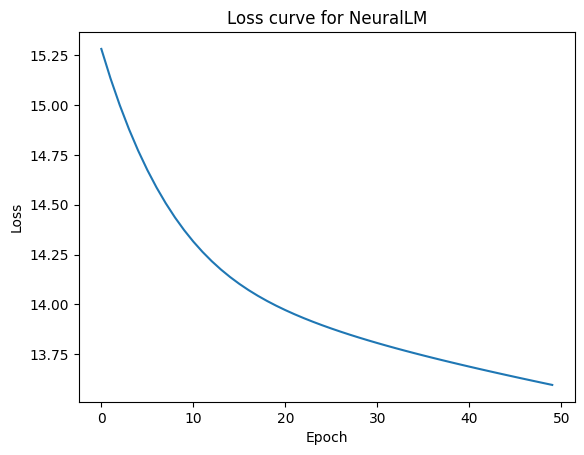

In [15]:
model = NeuralLM(vocab_size, emb_dim=100)
losses = model.fit(X, y, epochs=50, lr=0.1)

# Plot the loss curves
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curve for NeuralLM")
plt.show()

Now that you've hopefully seen the model improving, we can extract its weight matrices to use as the Embeddings.

We have the choice of using either one, or we could take the average of both.

In [16]:
# Get the embeddings from the model
embedding_matrix = (model.W1 + model.W2.T) / 2

print(cosine_similarity(
    embedding_matrix[dataset.stoi["frodo"]],
    embedding_matrix[dataset.stoi["sam"]]
))

print(cosine_similarity(
    embedding_matrix[dataset.stoi["gandalf"]],
    embedding_matrix[dataset.stoi["white"]]
))

print(cosine_similarity(
    embedding_matrix[dataset.stoi["mordor"]],
    embedding_matrix[dataset.stoi["frodo"]]
))

print(cosine_similarity(
    embedding_matrix[dataset.stoi["shire"]],
    embedding_matrix[dataset.stoi["aragorn"]]
))

0.10319770140665206
0.06361640778557101
-0.005768037833723058
0.05301869300509607


The word2vec cosine similarities are much better than this neural network's results. One possibility is that there is not enough data for the NN to outperform the word2vec.

## Part 3 - Playing with Word Vectors

The intensive parts of this assignment are over - now we'll play with pretrained embeddings, i.e. embeddings that someone else has trained.

We will use the GloVe embeddings from `gensim`, a Python library made for interacting with word vectors.

In the cells below, we will make our imports, load in our embeddings, and construct our numpy matrix.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import gensim.downloader as api
from pprint import pprint

def load_embedding_model():
    '''
    Loads the GloVe embeddings from gensim
    '''
    gensim_wv = api.load("glove-wiki-gigaword-200")
    print(f"Loaded embeddings with vocab size {len(gensim_wv.key_to_index)} with vector size {gensim_wv.vector_size}")
    return gensim_wv

In [18]:
# Load in the Embeddings (this can take ~8 minutes)
gensim_wv = load_embedding_model()

Loaded embeddings with vocab size 400000 with vector size 200


In [19]:
def get_embedding_matrix(gensim_wv):
    
    # Get the words in the vocab
    words = list(gensim_wv.index_to_key)
    stoi = {}
    M = []
    curInd = 0
    
    # Add the words to the matrix M
    for w in words:
        try:
            M.append(gensim_wv.get_vector(w))
            stoi[w] = curInd
            curInd += 1
        except KeyError:
            continue
    
    # Convert the list of vectors to a numpy matrix
    M = np.stack(M)
    print("Done.")

    return M, stoi

M, stoi = get_embedding_matrix(gensim_wv)
print(f"Shape of the embedding matrix: {M.shape}")

Done.
Shape of the embedding matrix: (400000, 200)


### Visualizing our embeddings

Now that we've created our matrix, let's work on visualizing them.

The issue with these embeddings is that they are in 200 dimensions. Most humans can't see beyond 3 dimensions, and it's convenient to plot in 2.

One nifty trick we can do to _squish_ down a vector in higher dimensions, to something in fewer dimensions, is to utilize **Dimensionality Reduction** techniques. This will learn the ambient structure in the data, and use it to capture as much information (technically, the "variance") in the amount of dimensions you want.

Most people go with [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) or [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) for this. We will go with a variant of [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition), a method to factorize a matrix.

You can read up on the documentation for the `sklearn` implementation [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In the cell below, implement the `reduce_to_k_dim` algorithm, where you run `TruncatedSVD` to squish your `(vocab_size, emb_dim)` matrix to `(vocab_size, K)`, where `K` is much smaller than `emb_dim`.

In [20]:
def reduce_to_k_dim(M, k=2):
    '''
    Reduce a matrix of shape (num_words, num_dim) to (num_words, k) dimensions
    '''
    n_iters = 10
    print(f"Running Truncated SVD over {n_iters} iterations...")


    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=None)
    M_reduced = svd.fit_transform(M)
        
    return M_reduced

# Reduce the matrix to 2 dimensions
M_reduced = reduce_to_k_dim(M, k=2)

# Normalize the rows to make them of unit length (helps with visualization)
M_reduced_unit = M_reduced / np.linalg.norm(M_reduced, axis=1, keepdims=True)

print(f"Shape of the reduced matrix: {M_reduced_unit.shape}")

Running Truncated SVD over 10 iterations...
Shape of the reduced matrix: (400000, 2)


In the cell below, we can plot out the embeddings from the reduced matrix. Note that since we squished the information coming from 200 dimensions into just 2, we won't have a perfect visualization by any means, but it's still worth studying.

In the cell below, you can fill `words_to_plot` with words whose embeddings you'd like to see in a scatterplot. If you wish to join pairs of words, you can pass them in as pairs in the `pairs_to_join` variable.

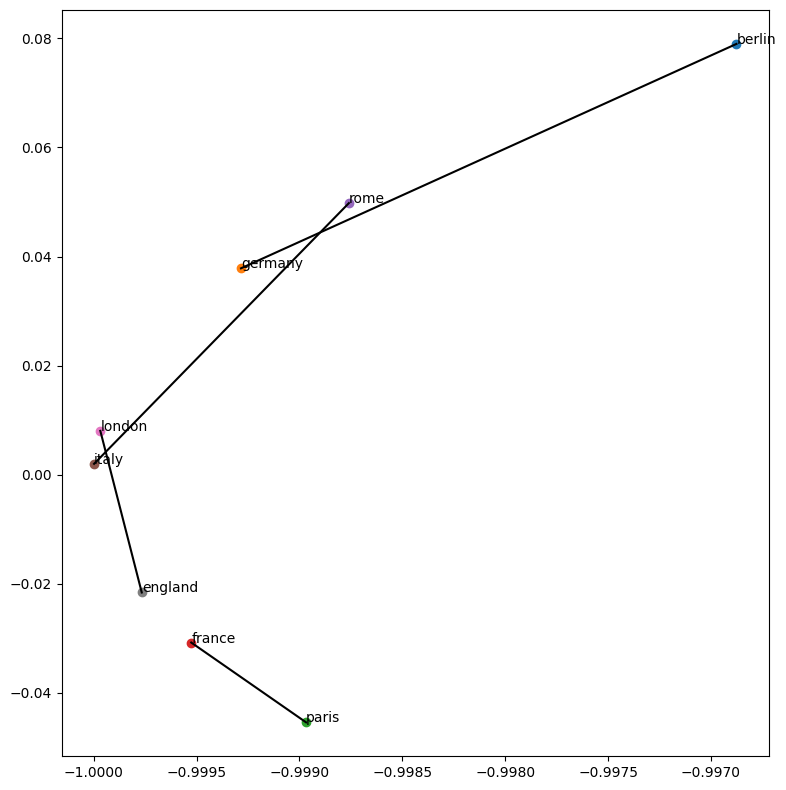

In [21]:
def plot_embeddings(M_reduced_unit, words, stoi, pairs_to_join):
    '''
    Produces a scatterplot of the embeddings with the words annotated

    Parameters:
    M_reduced_unit : np.ndarray
        The reduced matrix of embeddings
    words : List[str]
        The words to annotate
    '''
    fig, ax = plt.subplots(figsize=(8, 8))

    for i, txt in enumerate(words):
        word_ind = stoi.get(txt)
        ax.scatter(M_reduced_unit[word_ind, 0], M_reduced_unit[word_ind, 1])
        ax.annotate(txt, (M_reduced_unit[word_ind, 0], M_reduced_unit[word_ind, 1]))

    for pair in pairs_to_join:
        w1, w2 = pair
        w1_ind = stoi.get(w1)
        w2_ind = stoi.get(w2)
        ax.plot([M_reduced_unit[w1_ind, 0], M_reduced_unit[w2_ind, 0]], 
                [M_reduced_unit[w1_ind, 1], M_reduced_unit[w2_ind, 1]], 'k-')

    plt.tight_layout()
    plt.show()

words_to_plot = ["berlin", "germany", "paris", "france", "rome", "italy", "london", "england"]
pairs_to_join = [("berlin", "germany"), ("paris", "france"), ("rome", "italy"), ("london", "england")]
plot_embeddings(M_reduced_unit, words_to_plot, stoi, pairs_to_join)

### Analogies with Word Vectors

We can use vector arithmetic to create _analogies_.

For example, if we had an embedding matrix E, and we wanted to find the relationship between `king` and `man`, and `queen` and `woman`, we would find

$$E[\text{king}] - E[\text{man}] \approx E[\text{queen}] - E[\text{woman}]$$

`gensim` makes this really easy for us. To save time, we can use the `most_similar` function to capture the nearest neighbors to the vector you get when "constructing the parallelogram" (from lecture).

In [22]:
# "king is to man, as ??? is to woman"
gensim_wv.most_similar(
    positive=['woman', 'king'],
    negative=['man']
)

[('queen', 0.6978678107261658),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399126410484314),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]

These are not perfect by any means. Run the cell below to see one case of the arithmetic failing.

In [23]:
# "glove is to hand as ??? is to foot"
gensim_wv.most_similar(
    positive=['foot', 'glove'],
    negative=['hand']
)

[('45,000-square', 0.4922032654285431),
 ('15,000-square', 0.4649604558944702),
 ('10,000-square', 0.4544755816459656),
 ('6,000-square', 0.44975775480270386),
 ('3,500-square', 0.444133460521698),
 ('700-square', 0.44257497787475586),
 ('50,000-square', 0.4356396794319153),
 ('3,000-square', 0.43486514687538147),
 ('30,000-square', 0.4330596923828125),
 ('footed', 0.43236875534057617)]

Words have polysemy, meaning, each word can have multiple senses. One vector alone can't capture all its meanings. In this case, the vector for 'foot' mostly captured its usage in distance measurements, rather than as a body part. This could be because that was a more common usage in its training data.


Lastly, it's important to know that biases and stigmas are implicit inside these word embeddings. 

Run the cell below, to examine (a) which terms are most similar to "woman" and "profession" and most dissimilar to "man", and (b) which terms are most similar to "man" and "profession" and most dissimilar to "woman". 

Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [24]:
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint(gensim_wv.most_similar(positive=['man', 'profession'], negative=['woman']))
print('-'*25)
pprint(gensim_wv.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176787376404),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.49005505442619324),
 ('ethic', 0.4897659420967102),
 ('business', 0.4875852167606354),
 ('respected', 0.485920250415802),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572618961334),
 ('life', 0.4760662019252777)]
-------------------------
[('professions', 0.5957457423210144),
 ('practitioner', 0.49884122610092163),
 ('teaching', 0.48292139172554016),
 ('nursing', 0.48211804032325745),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.46937814354896545),
 ('educator', 0.46524327993392944),
 ('physicians', 0.4628995358943939),
 ('professionals', 0.4601394236087799)]


The words associated with 'man' and 'profession' seem to be related to being evaluated positively (eg. respected, regarded, skill).  The associated profession also seems to be related to business.

On the other hand, 'woman' is associated with specific jobs like teaching and nursing. There also isn't any associated positive evaulation like 'man' and 'profession' did.

This reflects the societal gender bias in the training data, where men would be positively regarded and considered as skilled. On the other hand, women are associated with very specific jobs, as nurses and teachers. This bias may not be malicious in nature, but just simply capturing the co-occurance of these terms. To detect one's own implicit biases, I recommend trying Harvard's Implicit Association Test (IAT).

# Fin.